In [10]:
!pip install pandas
!pip install pyarrow

   ---------------------------------------- 0.0/25.8 MB ? eta -:--:--
    --------------------------------------- 0.5/25.8 MB 3.4 MB/s eta 0:00:08
   - -------------------------------------- 1.0/25.8 MB 2.8 MB/s eta 0:00:09
   -- ------------------------------------- 1.6/25.8 MB 2.8 MB/s eta 0:00:09
   --- ------------------------------------ 2.1/25.8 MB 2.8 MB/s eta 0:00:09
   ---- ----------------------------------- 2.9/25.8 MB 2.8 MB/s eta 0:00:09
   ----- ---------------------------------- 3.4/25.8 MB 2.8 MB/s eta 0:00:08
   ------ --------------------------------- 3.9/25.8 MB 2.8 MB/s eta 0:00:08
   ------ --------------------------------- 4.2/25.8 MB 2.6 MB/s eta 0:00:09
   ------- -------------------------------- 4.7/25.8 MB 2.5 MB/s eta 0:00:09
   -------- ------------------------------- 5.2/25.8 MB 2.5 MB/s eta 0:00:09
   -------- ------------------------------- 5.5/25.8 MB 2.4 MB/s eta 0:00:09
   --------- ------------------------------ 6.0/25.8 MB 2.4 MB/s eta 0:00:09
   ---

In [6]:
import pandas as pd
from pathlib import Path

# Ruta base al directorio procesado
base_path = Path("../data/processed/fbref")

# Detectar todas las carpetas por temporada
season_dirs = sorted([d for d in base_path.iterdir() if d.is_dir() and d.name.startswith("season_")])

# Leer todos los archivos parquet por temporada
dfs = []
for season_dir in season_dirs:
    season = season_dir.name.split("_")[-1]
    parquet_files = list(season_dir.glob("*.parquet"))
    
    if not parquet_files:
        print(f"No se encontraron archivos Parquet en {season_dir}")
        continue

    df_season = pd.concat([pd.read_parquet(f) for f in parquet_files], ignore_index=True)
    df_season["Season"] = season
    dfs.append(df_season)

# Unir todas las temporadas
df = pd.concat(dfs, ignore_index=True)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

df.head()

,Round,Wk,Day,Date,Time,Home,Score,Away,Attendance,Venue,Referee,Home_Goals,Away_Goals,Season
0,Torneo Apertura,1.0,Fri,2024-01-26,15:00,UTC,1–0,Deportivo Garcilaso,None,Estadio Héroes de San Ramón,None,1,0,2024
1,Torneo Apertura,1.0,Sat,2024-01-27,15:00,Sporting Cristal,6–2,ADT Tarma,None,Estadio Alberto Gallardo,None,6,2,2024
2,Torneo Apertura,1.0,Sat,2024-01-27,17:30,Sport Huancayo,1–0,Sport Boys,None,Estadio Huancayo,None,1,0,2024
3,Torneo Apertura,1.0,Fri,2024-01-26,19:00,Melgar,2–3,Cusco,None,Estadio de la Universidad Nacional San A...,None,2,3,2024
4,Torneo Apertura,1.0,Sun,2024-01-28,14:30,Atlético Grau,1–1,Alianza Atlético,None,Estadio Campeones del 36,None,1,1,2024


In [7]:
import os

metrics_path = Path("../data/metrics/fbref")

# Detectar temporadas disponibles
seasons = [d for d in os.listdir(metrics_path) if d.startswith("season_")]
print(f"Temporadas disponibles: {seasons}")

Temporadas disponibles: ['season_2024', 'season_2025']


In [8]:
dfs = []
for season_dir in seasons:
    season = season_dir.split("_")[1]
    season_path = os.path.join(metrics_path, season_dir)
    parquet_files = [os.path.join(season_path, f) for f in os.listdir(season_path) if f.endswith(".parquet")]
    
    if not parquet_files:
        continue

    df_season = pd.concat([pd.read_parquet(f) for f in parquet_files], ignore_index=True)
    df_season["Season"] = season
    dfs.append(df_season)

df_all = pd.concat(dfs, ignore_index=True)
df_all.head()

,Date,Team,Opponent,GF,GA,Venue,GD,Result,Points,Matchday,CumulativePoints,Streak,Season
0,2024-01-27,ADT Tarma,Sporting Cristal,2,6,Away,-4,L,0,1,0,0,2024
1,2024-02-03,ADT Tarma,Cienciano,1,1,Home,0,D,1,2,1,0,2024
2,2024-02-11,ADT Tarma,CDC Santa Rosa,0,2,Away,-2,L,0,3,1,0,2024
3,2024-02-17,ADT Tarma,Mannucci,4,0,Home,4,W,3,4,4,1,2024
4,2024-02-25,ADT Tarma,Atlético Grau,2,2,Away,0,D,1,5,5,1,2024


In [9]:
# Ranking final por puntos acumulados
df_rank = df_all.groupby(["Season", "Team"]) \
               .agg({"CumulativePoints": "max"}) \
               .reset_index() \
               .sort_values(["Season", "CumulativePoints"], ascending=[True, False])

df_rank.head(10)

,Season,Team,CumulativePoints
16,2024,Universitario,77
13,2024,Sporting Cristal,74
10,2024,Melgar,70
2,2024,Alianza Lima,69
7,2024,Cusco,60
5,2024,Cienciano,52
0,2024,ADT Tarma,51
3,2024,Atlético Grau,51
1,2024,Alianza Atlético,44
4,2024,CDC Santa Rosa,39


In [17]:
from pathlib import Path
import pandas as pd

base_dir = Path("../data/metrics/fbref")
df_list = []

for season_path in base_dir.glob("season_*/effectiveness_by_venue/*.parquet"):
    season = season_path.parts[-3].split("_")[1]
    df = pd.read_parquet(season_path)
    print(f"Archivo: {season_path}")
    display(df.head())  # Mostrar contenido
    df["Season"] = season
    df_list.append(df)

# Validar que se encontró data
if df_list:
    df_effectiveness = pd.concat(df_list, ignore_index=True)
else:
    raise ValueError("No se encontraron archivos Parquet en effectiveness_by_venue.")


Archivo: ..\data\metrics\fbref\season_2024\effectiveness_by_venue\part-00000-e547b0cd-d230-4bd4-bc0a-1bef4912f6f1-c000.snappy.parquet


,Team,Venue,TotalPoints,GamesPlayed,PointsPerGame
0,Alianza Lima,Home,38,17,2.235294
1,Sport Boys,Home,26,17,1.529412
2,Cusco,Home,39,17,2.294118
3,U César Vallejo,Home,26,17,1.529412
4,Sporting Cristal,Home,46,17,2.705882


Archivo: ..\data\metrics\fbref\season_2025\effectiveness_by_venue\part-00000-2c06c541-4eb4-431f-abec-6d40a1b79930-c000.snappy.parquet


,Team,Venue,TotalPoints,GamesPlayed,PointsPerGame
0,Alianza Lima,Home,17,8,2.125000
1,Sport Boys,Home,11,7,1.571429
2,Cusco,Home,12,7,1.714286
3,Sporting Cristal,Home,18,7,2.571429
4,Sport Huancayo,Home,16,8,2.000000


In [19]:
# Filtrar solo temporada 2025
df_2025 = df_effectiveness[df_effectiveness["Season"] == "2025"]

# Pivot para comparar Home vs Away
pivot_2025 = df_2025.pivot_table(
    index="Team",
    columns="Venue",
    values="PointsPerGame"
).reset_index()

# Renombramos columnas para claridad
pivot_2025.columns.name = None
pivot_2025 = pivot_2025.rename(columns={
    "Home": "PPG_Home",
    "Away": "PPG_Away"
})

# Calcular diferencia
pivot_2025["EffectivenessDiff"] = pivot_2025["PPG_Home"] - pivot_2025["PPG_Away"]

# Top 10 equipos con mayor diferencia a favor en casa
pivot_2025.sort_values("EffectivenessDiff", ascending=False).head(10)


,Team,PPG_Away,PPG_Home,EffectivenessDiff
12,Juan Pablo II,0.142857,2.166667,2.023810
16,Sporting Cristal,0.875000,2.571429,1.696429
1,Alianza Atlético,1.428571,2.571429,1.142857
18,Universitario,1.571429,2.625000,1.053571
4,Atlético Grau,0.857143,1.857143,1.000000
14,Sport Boys,0.714286,1.571429,0.857143
0,ADT Tarma,0.875000,1.714286,0.839286
7,CDC Santa Rosa,0.857143,1.500000,0.642857
17,UTC,0.875000,1.428571,0.553571
11,Deportivo Garcilaso,1.375000,1.875000,0.500000


In [20]:
!pip install matplotlib seaborn

^C


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 169.6 kB/s eta 0:00:45
   -- ------------------------------------- 0.5/8.1 MB 169.6 kB/s eta 0:00:45
   ----- ---------------------------------- 1.0/8.1 MB 416.1 kB/s eta 0:00:17
   ------ --------------------------------- 1.3/8.1 MB 508.5 kB/s eta 0:00:14
   ------- -------------------------------- 1.6/8.1 MB 548.4 kB/s e

Matplotlib is building the font cache; this may take a moment.


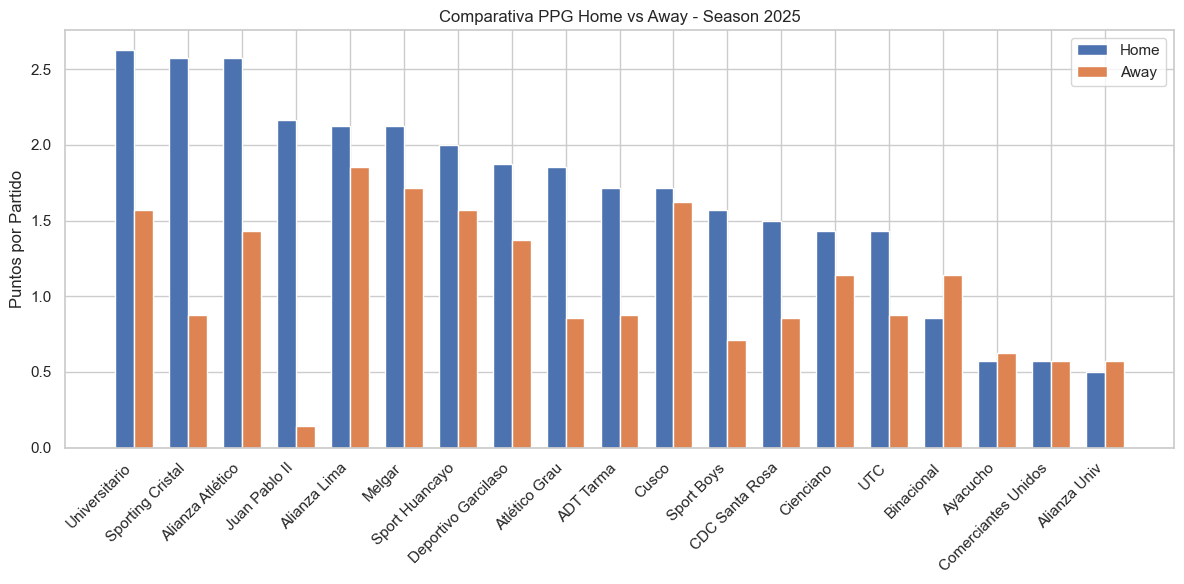

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Ordenar por PPG Home
pivot_sorted = pivot_2025.sort_values("PPG_Home", ascending=False)

# Gráfico
bar_width = 0.35
teams = pivot_sorted["Team"]
x = range(len(teams))

plt.bar(x, pivot_sorted["PPG_Home"], width=bar_width, label="Home")
plt.bar([i + bar_width for i in x], pivot_sorted["PPG_Away"], width=bar_width, label="Away")

plt.xticks([i + bar_width / 2 for i in x], teams, rotation=45, ha="right")
plt.ylabel("Puntos por Partido")
plt.title("Comparativa PPG Home vs Away - Season 2025")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\fabio\AppData\Local\Temp\ipykernel_27880\38923100.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pivot_sorted, x="Team", y="EffectivenessDiff", palette="coolwarm")


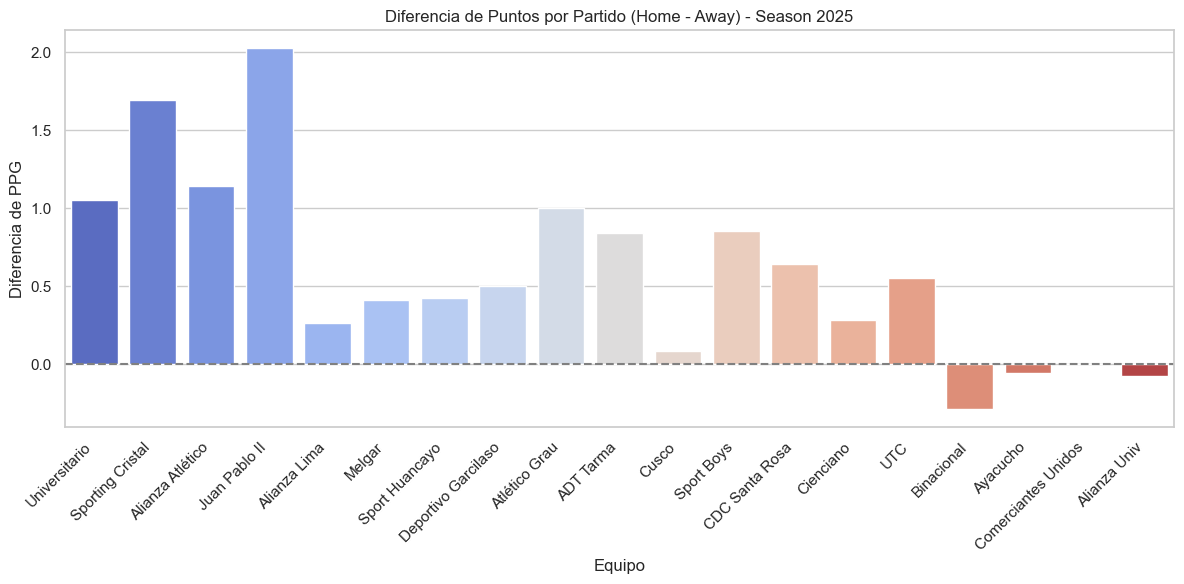

In [22]:
plt.figure(figsize=(12, 6))
sns.barplot(data=pivot_sorted, x="Team", y="EffectivenessDiff", palette="coolwarm")
plt.xticks(rotation=45, ha="right")
plt.title("Diferencia de Puntos por Partido (Home - Away) - Season 2025")
plt.ylabel("Diferencia de PPG")
plt.xlabel("Equipo")
plt.axhline(0, color="gray", linestyle="--")
plt.tight_layout()
plt.show()


C:\Users\fabio\AppData\Local\Temp\ipykernel_27880\636422453.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_away, x="Team", y="PPG_Away", ax=axs[0], palette="Blues_d")
C:\Users\fabio\AppData\Local\Temp\ipykernel_27880\636422453.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom_away, x="Team", y="PPG_Away", ax=axs[1], palette="Reds_d")


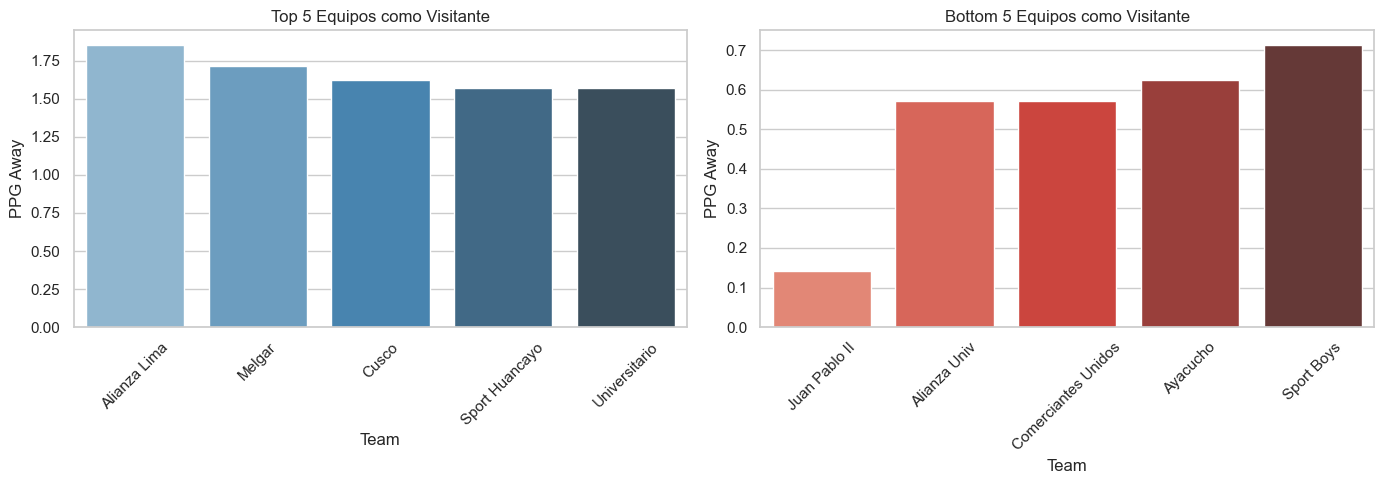

In [23]:
top_away = pivot_2025.sort_values("PPG_Away", ascending=False).head(5)
bottom_away = pivot_2025.sort_values("PPG_Away").head(5)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=top_away, x="Team", y="PPG_Away", ax=axs[0], palette="Blues_d")
axs[0].set_title("Top 5 Equipos como Visitante")
axs[0].set_ylabel("PPG Away")
axs[0].tick_params(axis='x', rotation=45)

sns.barplot(data=bottom_away, x="Team", y="PPG_Away", ax=axs[1], palette="Reds_d")
axs[1].set_title("Bottom 5 Equipos como Visitante")
axs[1].set_ylabel("PPG Away")
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


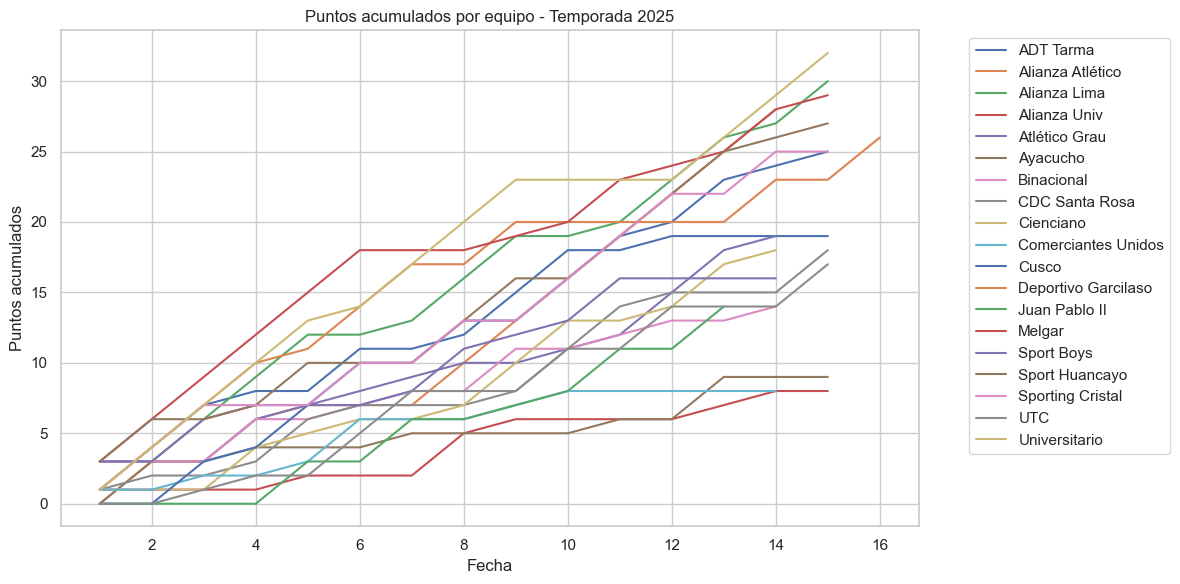

In [24]:
import matplotlib.pyplot as plt

# Filtrar solo 2025
df_2025 = df_all[df_all["Season"] == "2025"]

plt.figure(figsize=(12, 6))
for team in df_2025["Team"].unique():
    team_data = df_2025[df_2025["Team"] == team].sort_values("Matchday")
    plt.plot(team_data["Matchday"], team_data["CumulativePoints"], label=team)

plt.title("Puntos acumulados por equipo - Temporada 2025")
plt.xlabel("Fecha")
plt.ylabel("Puntos acumulados")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


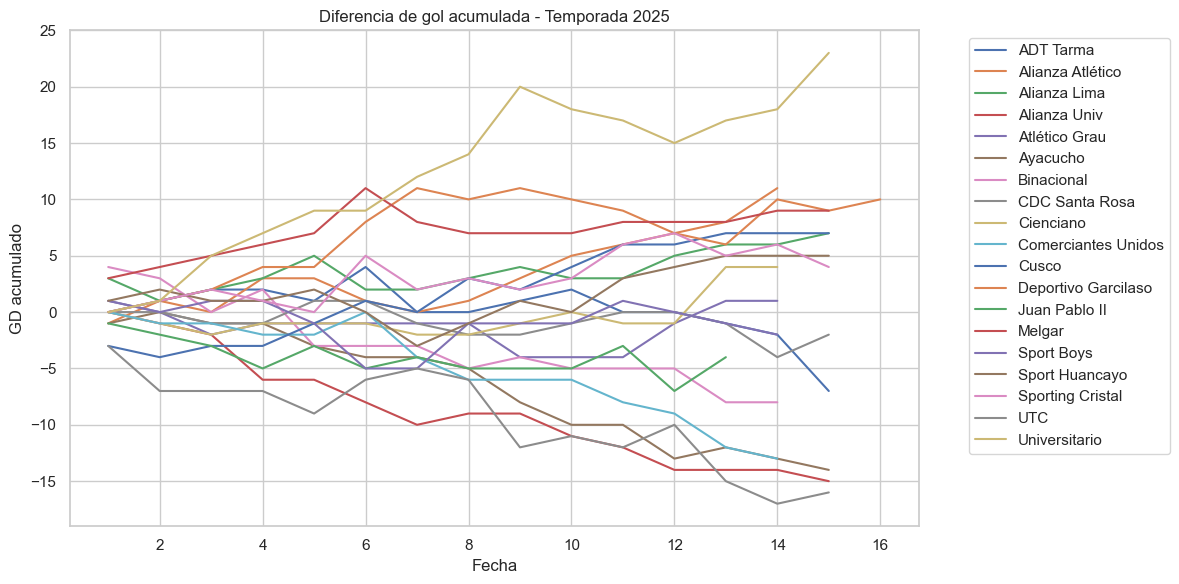

In [25]:
plt.figure(figsize=(12, 6))
for team in df_2025["Team"].unique():
    team_data = df_2025[df_2025["Team"] == team].sort_values("Matchday")
    plt.plot(team_data["Matchday"], team_data["GD"].cumsum(), label=team)

plt.title("Diferencia de gol acumulada - Temporada 2025")
plt.xlabel("Fecha")
plt.ylabel("GD acumulado")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


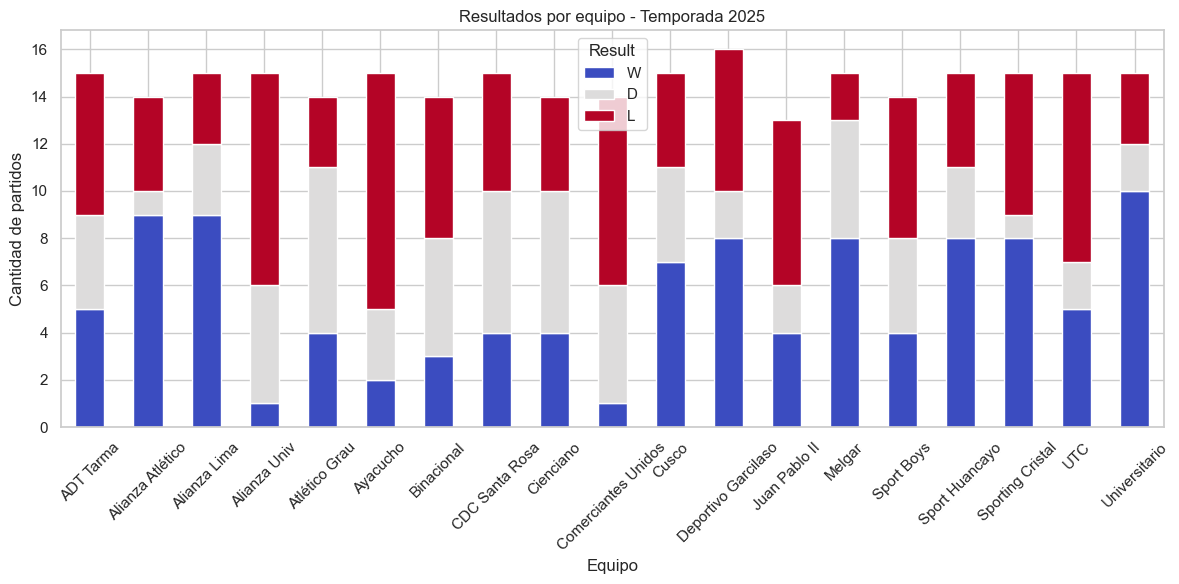

In [26]:
import seaborn as sns

result_counts = df_2025.groupby(["Team", "Result"]).size().unstack(fill_value=0)
result_counts = result_counts[["W", "D", "L"]]  # Asegurar orden

result_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Resultados por equipo - Temporada 2025")
plt.ylabel("Cantidad de partidos")
plt.xlabel("Equipo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


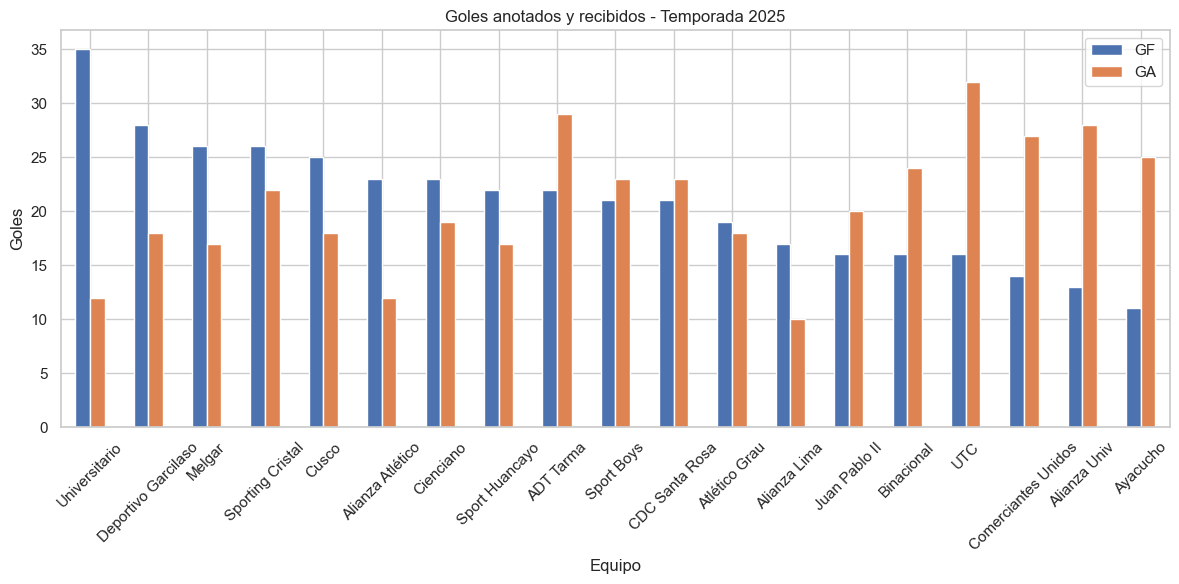

In [27]:
goal_stats = df_2025.groupby("Team").agg({"GF": "sum", "GA": "sum"}).sort_values("GF", ascending=False)

goal_stats.plot(kind="bar", figsize=(12, 6))
plt.title("Goles anotados y recibidos - Temporada 2025")
plt.ylabel("Goles")
plt.xlabel("Equipo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


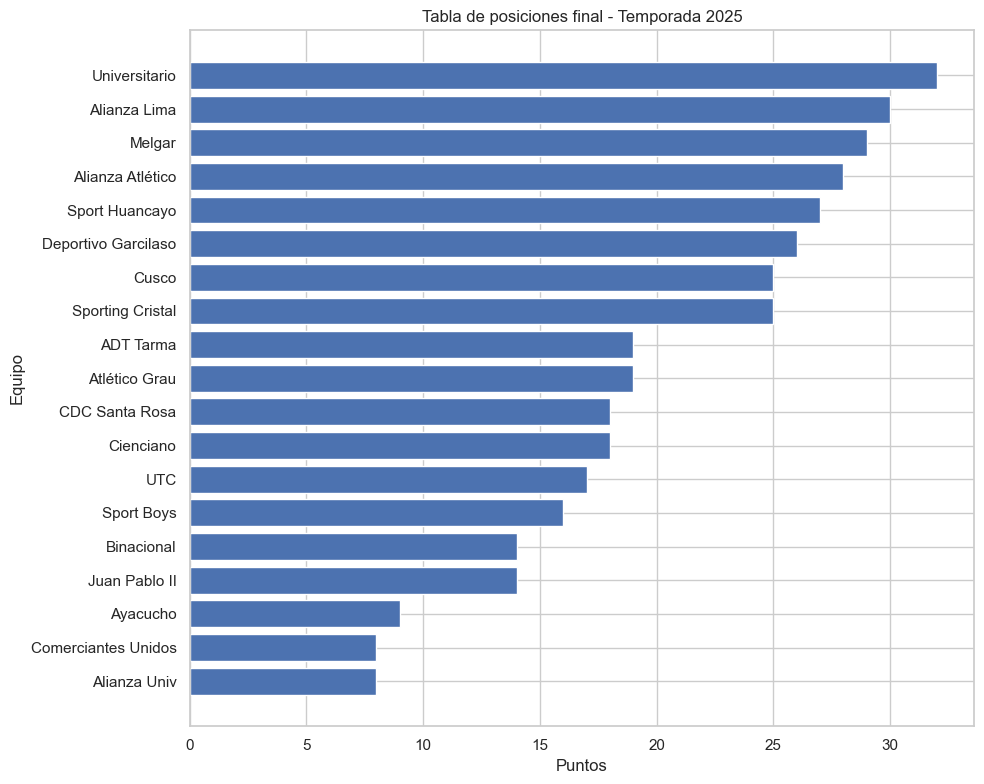

In [28]:
standings = (
    df_2025.groupby("Team")
    .agg(
        Matches=("Points", "count"),
        Wins=("Result", lambda x: (x == "W").sum()),
        Draws=("Result", lambda x: (x == "D").sum()),
        Losses=("Result", lambda x: (x == "L").sum()),
        Goals_For=("GF", "sum"),
        Goals_Against=("GA", "sum"),
        Goal_Diff=("GD", "sum"),
        Points=("Points", "sum")
    )
    .sort_values("Points", ascending=False)
)

plt.figure(figsize=(10, 8))
plt.barh(standings.index[::-1], standings["Points"][::-1])
plt.title("Tabla de posiciones final - Temporada 2025")
plt.xlabel("Puntos")
plt.ylabel("Equipo")
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()


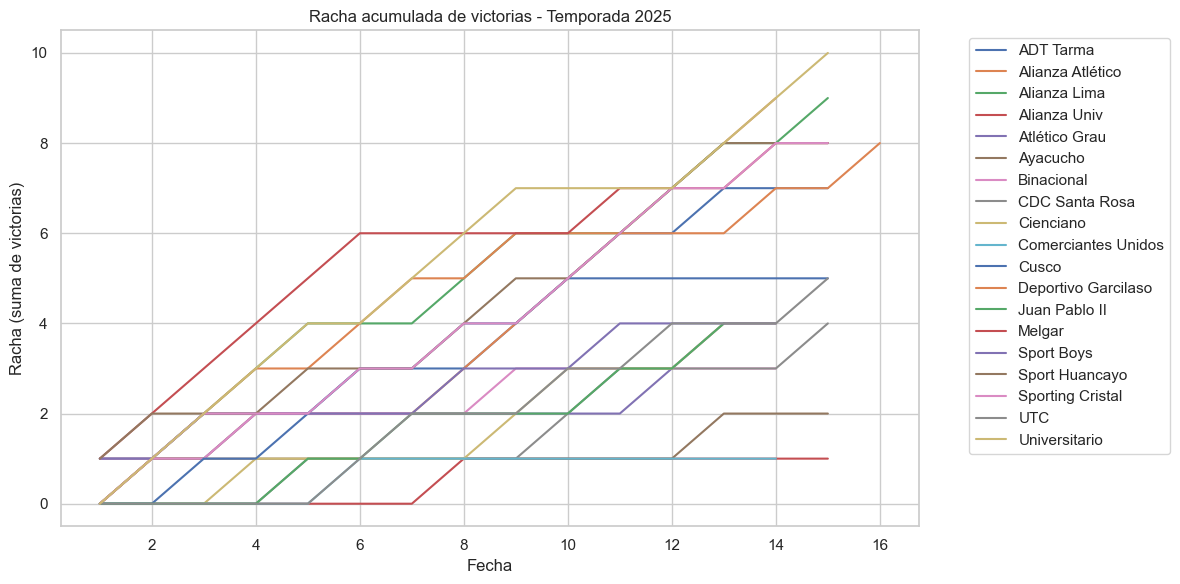

In [29]:
plt.figure(figsize=(12, 6))
for team in df_2025["Team"].unique():
    team_data = df_2025[df_2025["Team"] == team].sort_values("Matchday")
    plt.plot(team_data["Matchday"], team_data["Streak"], label=team)

plt.title("Racha acumulada de victorias - Temporada 2025")
plt.xlabel("Fecha")
plt.ylabel("Racha (suma de victorias)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


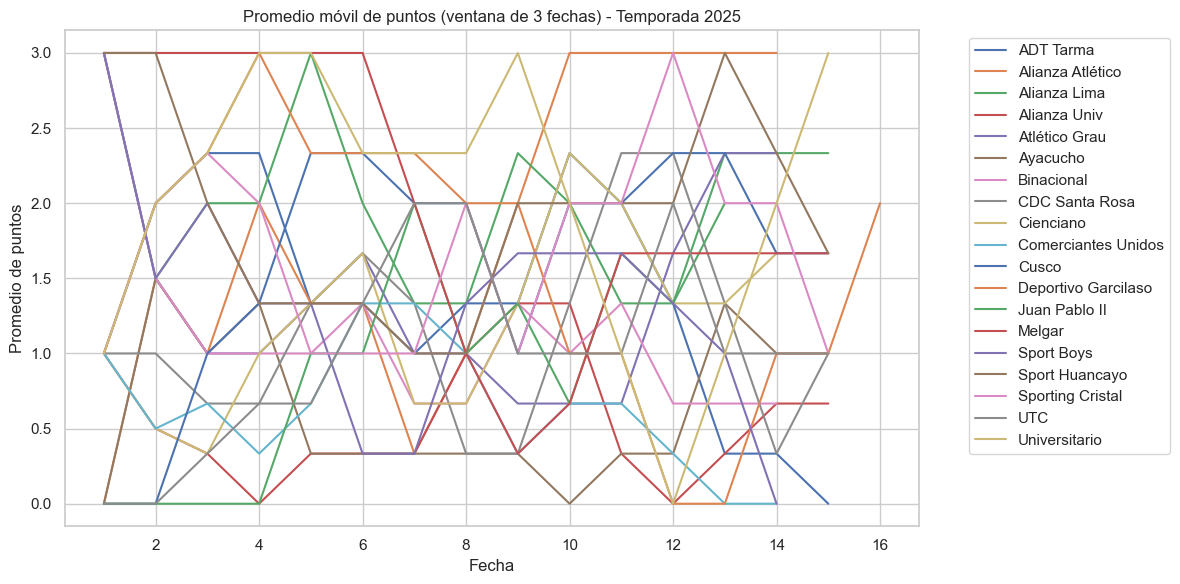

In [30]:
plt.figure(figsize=(12, 6))
for team in df_2025["Team"].unique():
    team_data = df_2025[df_2025["Team"] == team].sort_values("Matchday")
    rolling_avg = team_data["Points"].rolling(window=3, min_periods=1).mean()
    plt.plot(team_data["Matchday"], rolling_avg, label=team)

plt.title("Promedio móvil de puntos (ventana de 3 fechas) - Temporada 2025")
plt.xlabel("Fecha")
plt.ylabel("Promedio de puntos")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
